## PSFs and PSF utilities available in SimCADO

This notebook shows the PSF functionalities available in SimCADO

In [1]:
import simcado
import poppy
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
%matplotlib inline
from simcado import __data_dir__
print("SimCADO data directory is", __data_dir__)

SimCADO data directory is /home/mverdugo/simcado_work/simcado/data


### Generate a diffraction limited PSF using poppy

In [2]:
# Load EELT segments 
segs = simcado.psf.get_eelt_segments()

# generate diffraction limited PSF -  it takes its time
ideal_psf = simcado.psf.poppy_eelt_psf(segments=segs, wavelength=2.2, mode='wide', size=1024, 
                                       pix_res=0.004, filename=None) 


**Note:** The PSF can be save to a fits file by specifying the filename

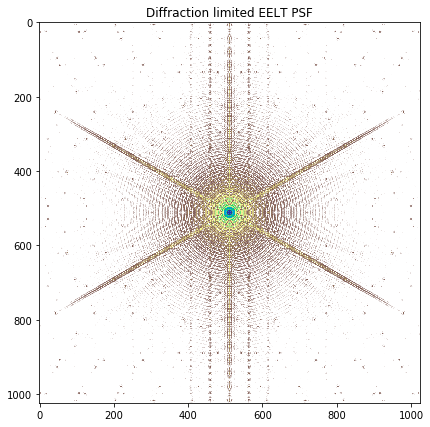

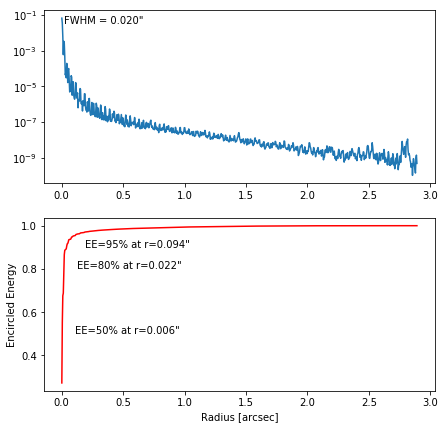

In [3]:
# Plotting the PSF and doing some analysis with Poppy

fig = plt.figure(figsize=(7, 7))
plt.imshow(np.log10(ideal_psf[0].data), vmin=-8, vmax=-3, cmap="terrain_r")
plt.title("Diffraction limited EELT PSF")

fig  = plt.figure(figsize=(7,7))
poppy.display_profiles(ideal_psf)

### Generate a seeing limited psf with seeing 0.8"

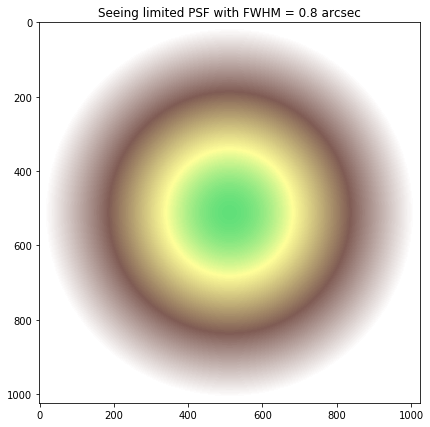

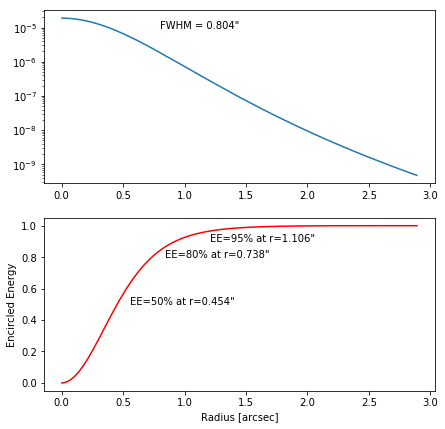

In [4]:
fwhm = 0.8 # arcsec
seeing_psf = simcado.psf.seeing_psf(fwhm=fwhm, psf_type="moffat", size=1024, 
                                    pix_res=0.004, filename=None)

fig=plt.figure(figsize=(7,7))
plt.imshow(np.log10(seeing_psf[0].data),vmin=-8,vmax=-3,cmap="terrain_r")
plt.title("Seeing limited PSF with FWHM = " + str(fwhm) + " arcsec")

fig  = plt.figure(figsize=(7,7))
poppy.display_profiles(seeing_psf)

### Generate a PSF with a user provided Strehl ratio

In [5]:
strehl = 0.5
strehl_psf = simcado.psf.poppy_ao_psf(strehl=strehl, mode='wide',  
                                      pix_res=0.004, size=1024, wavelength=2.2, filename=None)

Generating an E-ELT PSF at 2.2 [um]


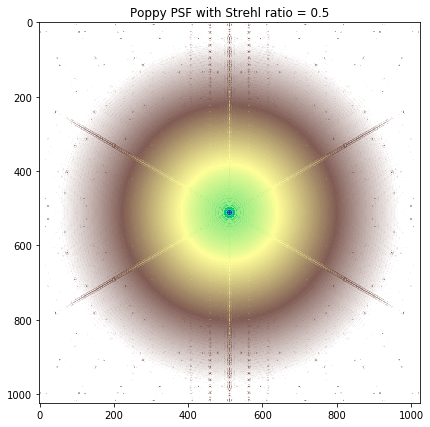

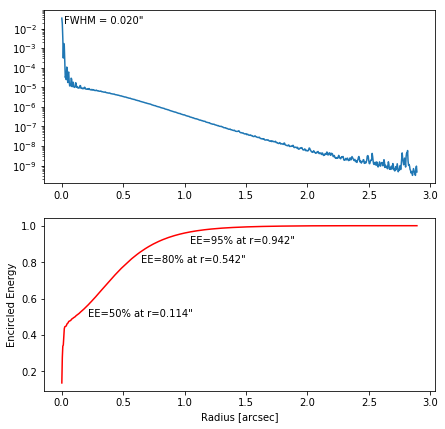

In [6]:
fig=plt.figure(figsize=(7,7))
plt.imshow(np.log10(strehl_psf[0].data),vmin=-8,vmax=-3,cmap="terrain_r")
plt.title("Poppy PSF with Strehl ratio = " + str(strehl))

fig  = plt.figure(figsize=(7,7))
poppy.display_profiles(strehl_psf)

### Loading external PSFs

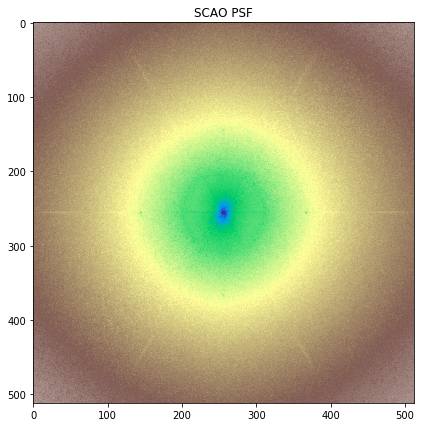

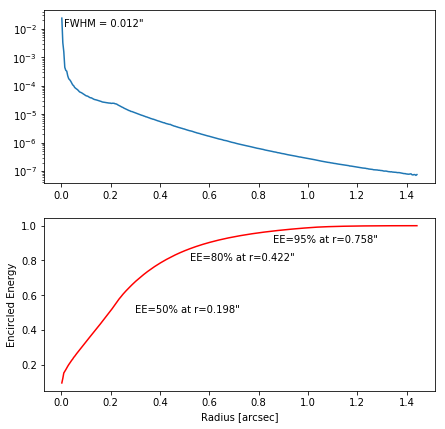

In [7]:
# SCAO PSF

scao_psf = fits.open(os.path.join(__data_dir__, "PSF_SCAO.fits"))
scao_psf[1].header["PIXELSCL"] = 0.004

plt.figure(figsize=(7,7))
plt.imshow(np.log10(scao_psf[1].data),vmin=-8,vmax=-3,cmap="terrain_r")
plt.title("SCAO PSF")

plt.figure(figsize=(7,7))
poppy.display_profiles(scao_psf, ext=1)

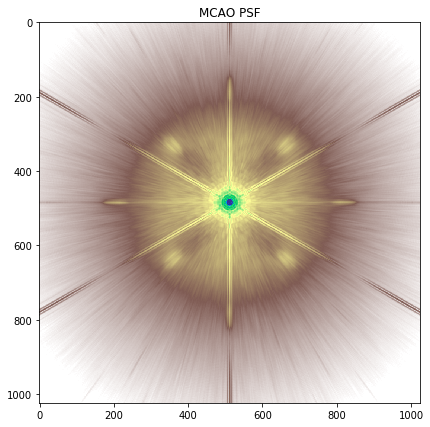

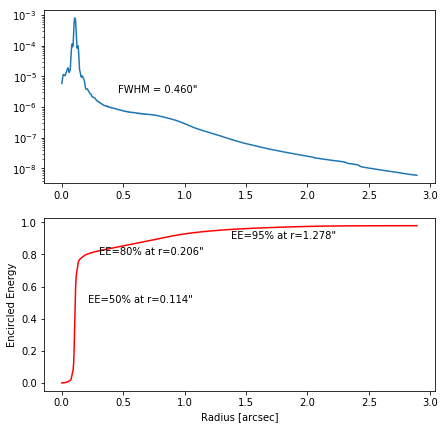

In [8]:
# MCAO PSF

mcao_psf = fits.open(os.path.join(__data_dir__, "PSF_MCAO.fits"))
mcao_psf[1].header["PIXELSCL"] = 0.004

plt.figure(figsize=(7,7))
plt.imshow(np.log10(mcao_psf[1].data), vmin=-8, vmax=-3, cmap="terrain_r")
plt.title("MCAO PSF")

plt.figure(figsize=(7,7))
poppy.display_profiles(mcao_psf, ext=1)


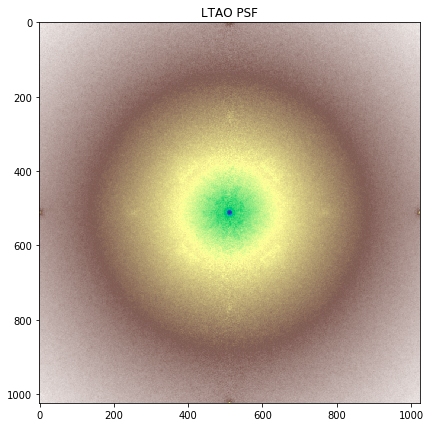

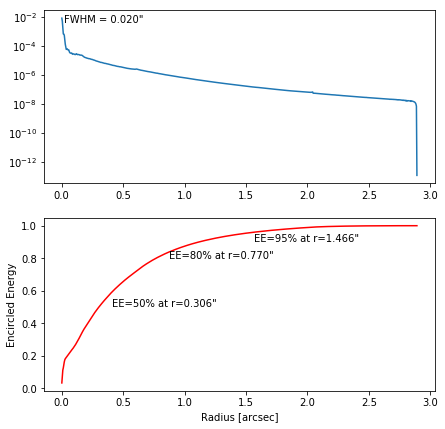

In [9]:
# LTAO PSF

ltao_psf = fits.open(os.path.join(__data_dir__, "PSF_LTAO.fits"))
ltao_psf[1].header["PIXELSCL"] = 0.004

plt.figure(figsize=(7,7))
plt.imshow(np.log10(ltao_psf[1].data), vmin=-8, vmax=-3, cmap="terrain_r")
plt.title("LTAO PSF")

plt.figure(figsize=(7,7))
poppy.display_profiles(ltao_psf, ext=1)

### Using these PSFs

Once that the PSFs are saved to the disk (or already stored there), there are number of ways to make them available to the simulation.

The standard way is just to update the simcado config file and edit the proper line

~~~
SCOPE_PSF_FILE          filename
~~~

It is also possible to update the SCOPE_PSF_FILE keyword within the scritps by calling UserCommands

```python
from simcado import UserCommands

cmds = UserCommands("default.config")
cmds["SCOPE_PSF_FILE"] = filename
```

or even on the fly when running the simulations

```python
import simcado as sim

source = sim.source... # any simcado source

hdu = sim.run(source, SCOPE_PSF_FILE=filename)
```